In [17]:
%run training_functions.ipynb

{'record': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
['train', 'validation', 'test']
['train', 'validation', 'test']
In, Out, get_ipython, exit, quit, open, accelerate, datasets, evaluate, math, np, os, peft, pickle, pytest, ipytest, pd, transformers, torch, time, threading, load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names, LoftQConfig, LoraConfig, get_peft_model, AutoModelForCausalLM, AutoTokenizer, pipeline, TrainingArguments, Trainer, SFTTrainer, SFTConfig, @py_builtins, @pytest_ar, model_from_pkl, ds_builder1, ds_builder2, ds_builder3, ds_gs, ds_gst1_train, ds_gst1_test, ds_gst2_train, ds_gst2_test, search_with_strings, map_data, print_trainable_parameters, metric, initialize_heartbeat, heartbeat, end_heartbeat, comp_metrics_output, compute_metrics, make_trainer, get_dataframe, get_training_output, mistral, mistral_tokenizer, m_tokeniz

## Imported Functions
1. model_from_pkl(model): extracts ML model from pkl file
2. map_data(data, model, tokenizer): performs preprocessing/tokenization on data
3. make_trainer(m_model, train_data, test_data, config, args): creates training object with model, training arguments, train/test data, a configuration, and evaluation function
4. compute_metrics(eval_pred): used in the trainer, calculates prediction accuracy/validation loss
5. get_training_output(trainer, keys: list): extracts data from training logs
6. get_dataframe(training_output: list, strategy): used in get_training_output, puts training data into dataframe/graph form

In [2]:
print(ds_gst1_train[0]['record'])

NZ_LIXJ01000001.1


In [3]:
print(ds_gst1_train[0]['text'][:1000])

CGACTCCGCACAGGCCCTAGGCGTGGTCCACGCATCGAGCGCGTGCGCCGTGGCATACACCCGGGCCACCCGTACGACCCTTCCGGCCGCCCCGTGTGCGCCCTCGTCGCCGAGTCCGCTCCGGCGCGCGCGGGCGCACTGCTGTTCCGCGCGGTGTCATGCGCTCCTCCCGTCCCGACATGCGCCTTTTTGCAGGGGAGAGGGAGGGGTAGGGTCGCGCGTACGCCTAGCACGGGGGAACGGTCTTGGGGGACGCAGTGGACGTACGGGTGGCGGCGATCGCCAGTCTCACACCGCTCGAAGAACTCGACAGCGATCCGTTCCTCGTGGACACCCGCAGCCAGCACGACATGTGCGCACGCTGGGCCGCGGACAAGGGGTACGTCGTCACCCGCCAGCTCCGCTTCTACGGGCTGCGCCCCGATCACCACGCCCTGTGGAGCGATGTCGAGAGCGGCGACGTCGAGGTGTTCGTCGCCGCCAACGACCGGGTGCTGGAACGGGCCCTCACGTCGGTCGCGGAGTTCGCCGCGGAGTGCGCGCGGCGCGGCGTGCGTCTGGAGATCGCCGGGCTGGACGAGCCGCCGTACAACGCCGGCACGAAGGCGAGCGTGCATCGCAGGCTCTCCATGCCCACCGCCGGTTACGACGGCCGCTGACGCACTCCGCCTCCACTGCCGGCTCGCGGCCCCTGCCCTCGTCCCGGCCCCGTCCCTTCCGCGGCTTGCCGTCGGGCTGTGACAGGCTGGGGGACAGGGTCCGCAGCGGCGGGGCCCGGACGTGAGGTGGTTGAGGCGTGGGTGACGGGCGATGGCGAACGGTCGGCAACGCCCTGATGCGAGTGGCCGTGGTGTGGGCGGTCTCCACGCTCACGATGCTGGTGCTCGCCGGGGTGCTGCCGGAGTTCCGGCTCCAGTCGGACGACGGCGACAGCATCACCAAGACCGCGTTCACCGCGGCCTGGGGCGCCGGAGCGTTCGGCCTGCTCTCCGCACTCGTC

In [4]:
mistral, mistral_tokenizer=model_from_pkl("Mistral-7B-Instruct-v0.1")

In [5]:
m_tokenized_genome_samples=map_data(ds_gs, mistral, mistral_tokenizer)

In [6]:
m_tokenized_stage1_train=map_data(ds_gst1_train, mistral, mistral_tokenizer)
m_tokenized_stage1_test=map_data(ds_gst1_test, mistral, mistral_tokenizer)

In [7]:
m_tokenized_stage2_train=map_data(ds_gst2_train, mistral, mistral_tokenizer)
m_tokenized_stage2_test=map_data(ds_gst2_test, mistral, mistral_tokenizer)

In [8]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [9]:
mis_lora_model=get_peft_model(mistral, config)
print_trainable_parameters(mis_lora_model)

trainable params: 3407872 || all params: 7245139968 || trainable%: 0.05


In [10]:
m_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps", 
                                    logging_steps=50, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                    fp16=True))

# Using the SFTConfig default values provides us with...
# num_train_epochs = 3.0
# eval_strategy: typing.Union[transformers.trainer_utils.IntervalStrategy, str] = 'no'
# per_device_train_batch_size = 8
# learning_rate = 2e-5
# gradient_checkpointing=False

In [11]:
m_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.628000,2.467054
100,0.610000,2.442320
150,0.606100,2.433809
200,0.603300,2.428757
250,0.602300,2.425537
300,0.602600,2.423740
350,0.601400,2.422914
400,0.601500,2.422394
450,0.600200,2.421545
500,0.600900,2.421174


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=705, training_loss=0.6040979412430567, metrics={'train_runtime': 1546.0661, 'train_samples_per_second': 14.553, 'train_steps_per_second': 0.456, 'total_flos': 9.8344875589632e+17, 'train_loss': 0.6040979412430567})

In [14]:
m_trainer.args.eval_strategy.value

'steps'

,loss,eval_loss
steps,,
50,0.6280,2.467054
100,0.6100,2.442320
150,0.6061,2.433809
200,0.6033,2.428757
250,0.6023,2.425537
300,0.6026,2.423740
350,0.6014,2.422914
400,0.6015,2.422394
450,0.6002,2.421545


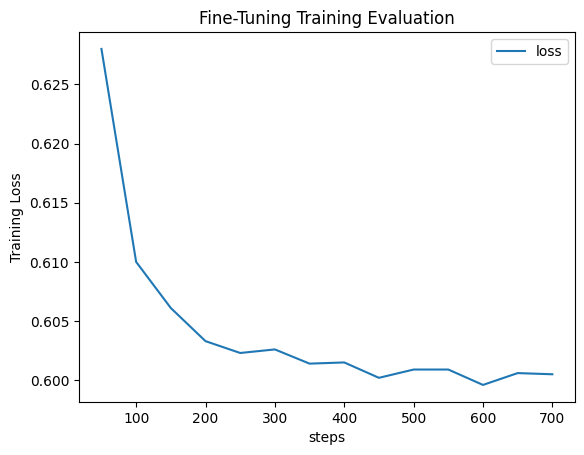

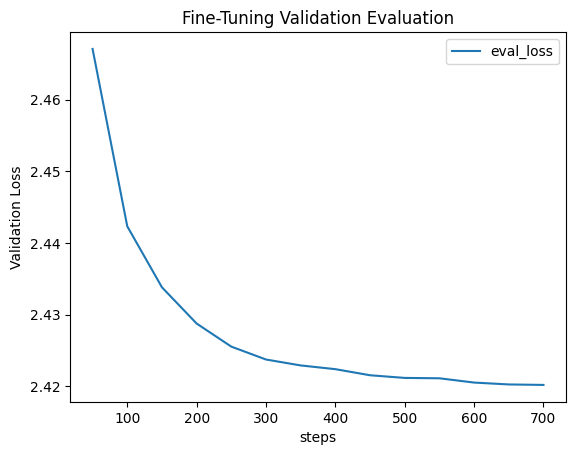

In [19]:
output=get_training_output(m_trainer, ['loss', 'eval_loss'])
#output=get_training_output(m_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [20]:
m2_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps", 
                                    logging_steps=2, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                   fp16=True))

In [21]:
m2_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.595800,2.417644
2,0.589900,2.415405
3,0.599000,2.414194


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=705, training_loss=0.5991229510476404, metrics={'train_runtime': 1338.3303, 'train_samples_per_second': 16.812, 'train_steps_per_second': 0.527, 'total_flos': 9.8344875589632e+17, 'train_loss': 0.5991229510476404})

,eval_loss,loss
epoch,,
1.0,2.417644,NaN
2.0,2.415405,0.5899
3.0,2.414194,NaN


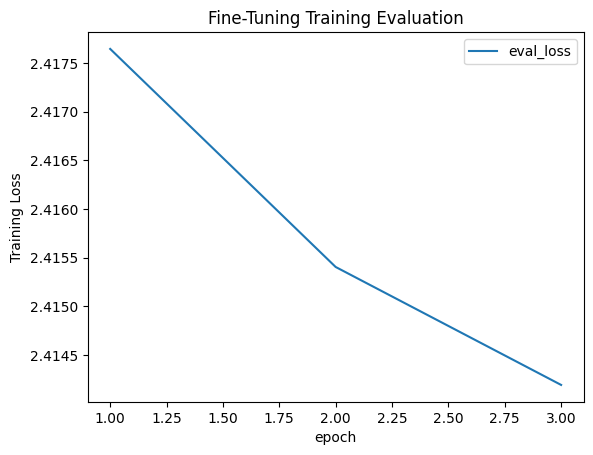

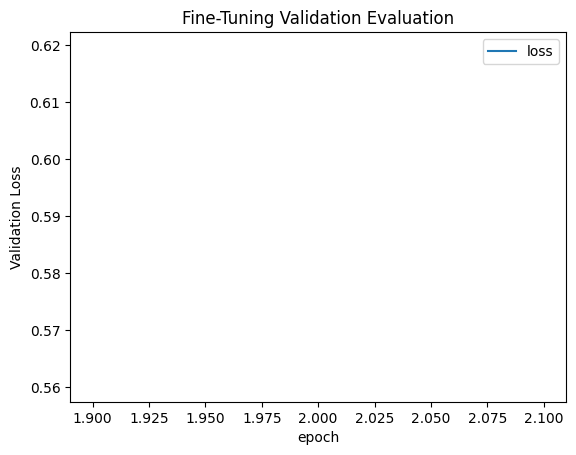

In [22]:
output=get_training_output(m2_trainer, ['loss', 'eval_loss'])
#output=get_training_output(m2_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [23]:
m_trainer.model.save_pretrained('./fine_tuned/mis/')
m2_trainer.model.save_pretrained('./fine_tuned/mis2/')

In [24]:
m_trainer.processing_class.save_pretrained('./fine_tuned/mis_token/')

('./fine_tuned/mis_token/tokenizer_config.json',
 './fine_tuned/mis_token/special_tokens_map.json',
 './fine_tuned/mis_token/tokenizer.model',
 './fine_tuned/mis_token/added_tokens.json',
 './fine_tuned/mis_token/tokenizer.json')

In [25]:
m2_trainer.processing_class.save_pretrained('./fine_tuned/mis2_token/')

('./fine_tuned/mis2_token/tokenizer_config.json',
 './fine_tuned/mis2_token/special_tokens_map.json',
 './fine_tuned/mis2_token/tokenizer.model',
 './fine_tuned/mis2_token/added_tokens.json',
 './fine_tuned/mis2_token/tokenizer.json')